# Processing the Data

Our dataset is collected from three different sources: Xeno-Canto, iNaturalist and the Colombian Sound Archive. Of the three sources, the Xeno-Canto website is the only one that allows its users to give a rating from 0 to 5 to uploaded sound clips. This rating can be a good proxy for the quality of the bird call, or other species' sound in the audio clip. In this notebook, the `rating` column will be used to filter the data. As previously stated, iNat and CSA do not have this feature, therefore in `train.csv` they have 0 in the `rating` column.

# Imports

In [1]:
from utility_data import *
from utility_plots import *
import matplotlib.pyplot as plt

## Setting up the dataset

In [2]:
dataset = AudioDataset(
    datafolder="data",
    metadata_csv="train_proc_yamn.csv",
    audio_dir="train_proc",
    feature_mode='mel',
    m=1
)
data = dataset.data

## Distribution of labels

First, we need to filter to audios that have rating > 0, we will call these `rated_audios`. Let's look at how the ratings in the Xeno-Canto database are distributed:

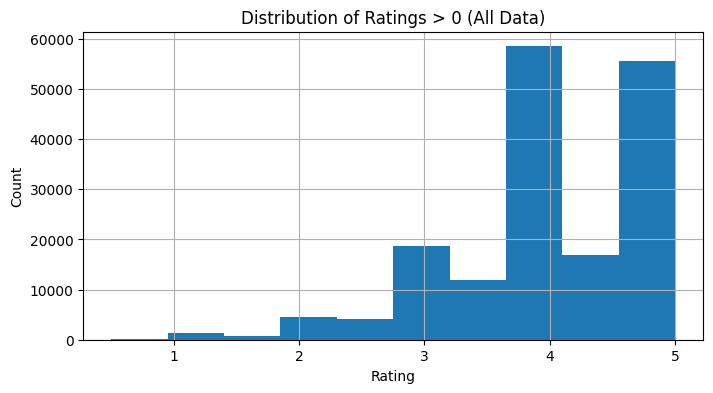

In [3]:
rated_audios = data[data['rating'] > 0]

plt.figure(figsize=(8, 4))
rated_audios['rating'].hist(bins=10)
plt.title("Distribution of Ratings > 0 (All Data)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


Most audio clips are rated above 3.5. The next step is to make sure we don't lose any representation of data if we remove low-rated labels. As seen from the previous notebook, we have 206 labels in total, let's see how many of these are present in the Xeno-Canto batch. Next, let's look at how many labels we would lose if we only kept data that was rated higher than 3.5

In [4]:
rating_thresh = 3.5
rated_labels = rated_audios['primary_label'].unique()
high_rated_labels = rated_audios[rated_audios['rating'] > rating_thresh]['primary_label'].unique()
lost_labels = set(rated_labels) - set(high_rated_labels)

print(f"Total labels: {len(rated_labels)}")
print(f"Labels lost if filtering (rating > {rating_thresh}): {len(lost_labels)}")
print("Lost labels:", lost_labels)


Total labels: 171
Labels lost if filtering (rating > 3.5): 2
Lost labels: {'41970', '126247'}


Out of 206 labels, 171 are represented in Xeno-Canto. Removing the low-rated samples would lose '41970' and '126247', the Jaguar and Spotted Foam-nest Frog respectively. Let's see if any of the other sources have these animals recorded.

In [5]:
jaguar_mask = (data['primary_label'] == '41970') & (data['collection'] != 'XC')
frog_mask = (data['primary_label'] == '126247') & (data['collection'] != 'XC')

print(f'Samples of Jaguar outside of Xeno-Canto: {len(data[jaguar_mask])}')
print(f'Samples of Spotted Foam-nest Frog outside of Xeno-Canto: {len(data[frog_mask])}')

Samples of Jaguar outside of Xeno-Canto: 13
Samples of Spotted Foam-nest Frog outside of Xeno-Canto: 19


The species wouldn't be completely lost if we removed all Xeno-Canto instances, yet since we have no way of verifying the quality of the other samples, we will still insert the highest rated samples of these species back into the dataset. We will be restricting to the top 5 examples of each species.

In [6]:
top_examples = []

for label in lost_labels:
    top = rated_audios[rated_audios['primary_label'] == label].sort_values(by='rating', ascending=False).head(5)
    top_examples.append(top)

top_lost_label_examples = pd.concat(top_examples)

In [7]:
mask = (data['rating'] > rating_thresh) | (data['rating'] == 0)
filtered_data = data[mask]
combined_data = pd.concat([filtered_data, top_lost_label_examples])

In [8]:
removed = len(data)-len(combined_data)
print(f"Removed {removed} audio clips out of {len(data)}, which counts for {removed/len(data)}% of the data")
print(f'There are {len(combined_data['primary_label'].unique())} unique primary labels in the data.')

Removed 41593 audio clips out of 216265, which counts for 0.19232423184518993% of the data
There are 206 unique primary labels in the data.


Removing all of the low rated data samples only resulted in a decrease in size of 0.19% in the data. We maintained all the labels, and made sure that we had the best samples available for the Xeno-Canto audios. Unfortunately, this is not enough to ensure the highest quality of data. Some more processing will need to be done on the other collection sources.

# Yamnet Filtering

Filtering by rating was a simple improvement to the quality of our data, but it only affected a very small portion of the whole dataset. We need a way to take the vast amount of audio data we have, and ensure that what we feed into the model is the most distilled and coherent portion of the audio. We will do this by splitting every audio clip into 5 second segments, padding the end of the audio with silence if necessary. Not only will this help to standardize the length of our data, it will also allow us to work with smaller chunks of it. In addition, when looking at the final soundscapes we will take a similar approach of splitting up the block into a smaller segment of 5 seconds. 

These 5 second segments will be passed through YAMNet, a deep net that predicts 521 audio event classes. YAMNet will classify the audios with tags like "Silence", "Animal", and "Speech", which we will use to filter the data. Audios that are classified as silence, are removed, as they don't have any information that the model will train from. We will select a subset of the classified audios, the ones whose label pertains to animal and nature, and we will start performing curriculum learning with these. To slowly improve the performance of the model, we will then reintroduce the more noisier and less clear audios into the pool.

In [9]:
data['yamnet'].value_counts().head(15)

yamnet
Animal                                     115169
Silence                                     27528
Outside, rural or natural                   12563
Wild animals                                 9367
Speech                                       7049
Environmental noise                          6737
Insect                                       5529
Cricket                                      4420
Bird                                         4394
Vehicle                                      3199
Water                                        1962
Bird vocalization, bird call, bird song      1488
White noise                                  1060
Frog                                         1056
Snake                                        1055
Name: count, dtype: int64

In [10]:
identified_labels = data['yamnet'].unique()
selected_labels = ['Animal', 
            'Wild animals', 
            'Insect', 
            'Cricket',
            'Bird', 
            'Bird vocalization, bird call, bird song', 
            'Frog', 'Snake', 
            'Whistling', 
            'Owl', 
            'Crow', 
            'Rodents, rats, mice', 
            'Livestock, farm animals, working animals', 
            'Pig', 
            'Squeak', 
            'Domestic animals, pets', 
            'Dog', 
            'Turkey', 
            'Bee, wasp, etc.', 
            'Duck', 
            'Chicken, rooster', 
            'Horse', 
            'Goose', 
            'Squawk', 
            'Chirp tone', 
            'Sheep', 
            'Pigeon, dove']

leftover = set(identified_labels) - set(selected_labels)
counts = data['yamnet'].value_counts()
leftover_counts = counts[counts.index.isin(leftover)]
print(leftover_counts.to_string())

yamnet
Silence                            27528
Outside, rural or natural          12563
Speech                              7049
Environmental noise                 6737
Vehicle                             3199
Water                               1962
White noise                         1060
Inside, small room                  1021
Pink noise                           915
Music                                747
Noise                                642
Stream                               625
Rustle                               554
Spray                                494
Hiss                                 483
Wind                                 461
Whistle                              385
Rail transport                       312
Alarm                                298
Rain                                 230
Aircraft                             216
Breathing                            198
Liquid                               173
Radio                                139
Rub      

### Putting the two together

In [11]:
restricted = combined_data[combined_data['yamnet'].apply(lambda x : x in selected_labels)]
restricted['primary_label'].nunique()

199

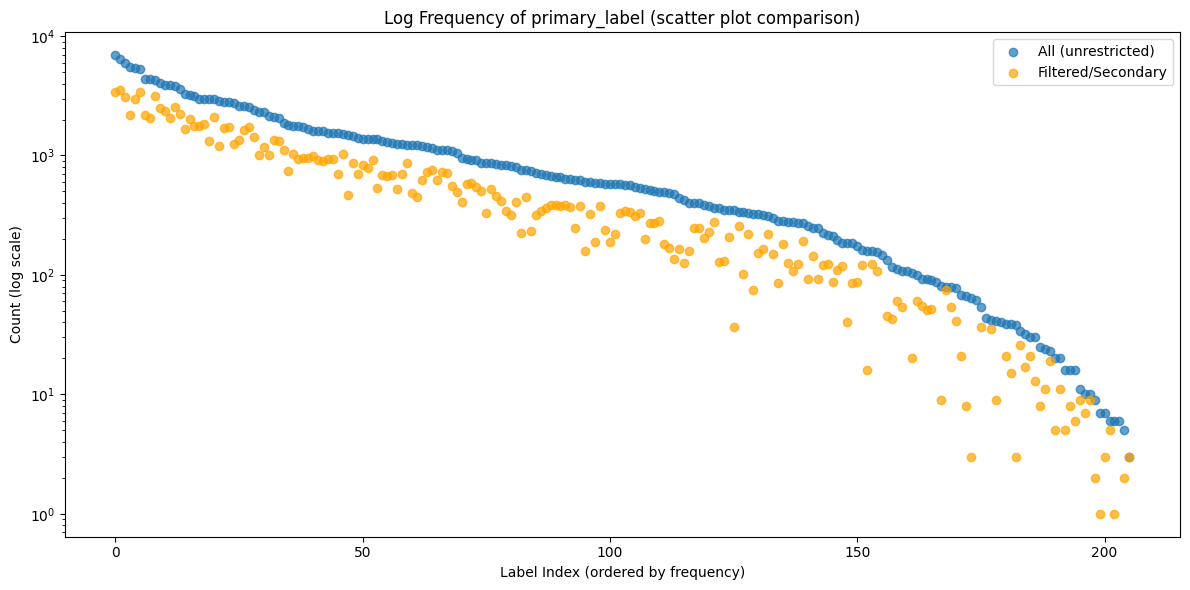

In [12]:
counts_primary = data["primary_label"].value_counts().sort_values(ascending=False)
counts_secondary = restricted["primary_label"].value_counts()

# Align both series to same x-axis
all_labels = counts_primary.index
y1 = counts_primary.values
y2 = [counts_secondary.get(label, 0) for label in all_labels]  # 0 if label not in second set

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(range(len(all_labels)), y1, label='All (unrestricted)', alpha=0.7)
plt.scatter(range(len(all_labels)), y2, label='Filtered/Secondary', alpha=0.7, color='orange')
plt.yscale('log')
plt.title('Log Frequency of primary_label (scatter plot comparison)')
plt.xlabel('Label Index (ordered by frequency)')
plt.ylabel('Count (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

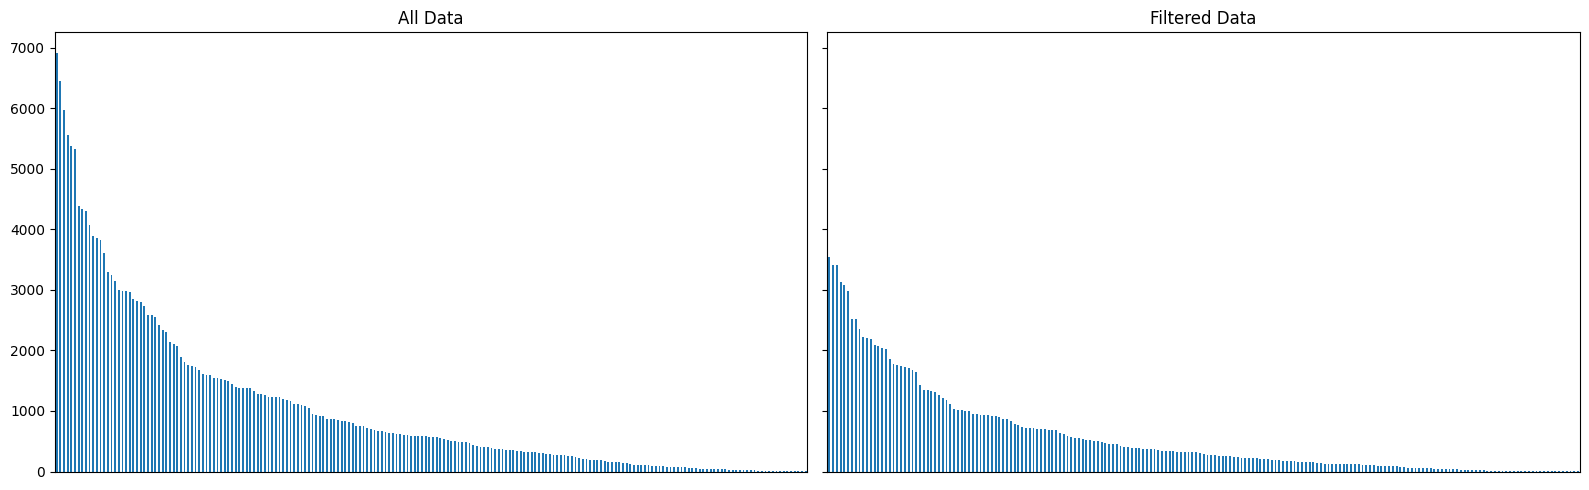

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5), sharey=True)

# Plot for full data
data["primary_label"].value_counts().sort_values(ascending=False).plot(
    kind='bar', ax=axes[0]
)
axes[0].get_xaxis().set_visible(False)
axes[0].set_title("All Data")

# Plot for clean_data
restricted["primary_label"].value_counts().sort_values(ascending=False).plot(
    kind='bar', ax=axes[1]
)
axes[1].get_xaxis().set_visible(False)
axes[1].set_title("Filtered Data")

plt.tight_layout()
plt.show()
